# Week 7

## Part 1

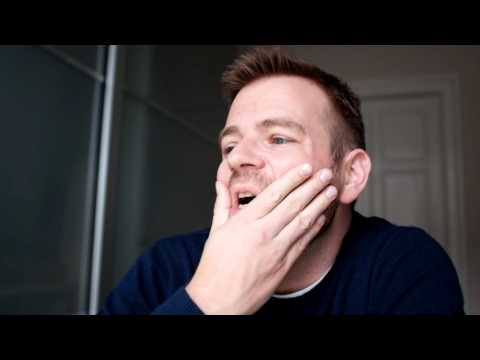

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

# Part 2 Community detection

In [2]:
import pandas as pd
import nltk

# Load the data
url = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt'
data = pd.read_csv(url)
data.head()

# Create a dictionary of genres
genres = {}
for i in range(len(data)):
    artist = data['artist'][i]
    genre = data['genre'][i]
    genres[artist] = genre





,0
0,"{""A Thousand Horses"": [""country"", ""country roc..."


In [3]:
import networkx as nx

# Sample data as a dictionary
artist_genres = {
    "A Thousand Horses": ["country", "country rock", "southern rock"],
    "A.P. Carter": ["country", "folk", "gospel"],
    "Aaron Barker": ["country"],
    "Aaron Benward": ["country", "christian music"],
    "Aaron Lewis (musician)": ["alternative metal", "post-grunge", "nu metal", "country rock", "alternative country"],
    "Aaron Lines": ["country"],
    "Aaron Neville": ["soul", "country", "gospel", "jazz", "pop"],
    "Aaron Pritchett": ["country"],
    "Aaron Watson": ["country", "red dirt", "texas country"],
    "Ace in the Hole Band": ["alternative country", "neotraditional country", "western swing"],
    # Add more artists as needed
}

# Create an undirected graph
G = nx.Graph()

# Add nodes and their genres as attributes
for artist, genres in artist_genres.items():
    G.add_node(artist, genres=genres)

# Add edges between artists who share genres
for artist1, genres1 in artist_genres.items():
    for artist2, genres2 in artist_genres.items():
        if artist1 != artist2:
            common_genres = set(genres1).intersection(genres2)
            if common_genres:  # Create an edge if they share any genre
                G.add_edge(artist1, artist2, weight=len(common_genres))  # Weight by the number of common genres

# Print undirected graph
print(G.edges(data=True))


[('A Thousand Horses', 'A.P. Carter', {'weight': 1}), ('A Thousand Horses', 'Aaron Barker', {'weight': 1}), ('A Thousand Horses', 'Aaron Benward', {'weight': 1}), ('A Thousand Horses', 'Aaron Lewis (musician)', {'weight': 1}), ('A Thousand Horses', 'Aaron Lines', {'weight': 1}), ('A Thousand Horses', 'Aaron Neville', {'weight': 1}), ('A Thousand Horses', 'Aaron Pritchett', {'weight': 1}), ('A Thousand Horses', 'Aaron Watson', {'weight': 1}), ('A.P. Carter', 'Aaron Barker', {'weight': 1}), ('A.P. Carter', 'Aaron Benward', {'weight': 1}), ('A.P. Carter', 'Aaron Lines', {'weight': 1}), ('A.P. Carter', 'Aaron Neville', {'weight': 2}), ('A.P. Carter', 'Aaron Pritchett', {'weight': 1}), ('A.P. Carter', 'Aaron Watson', {'weight': 1}), ('Aaron Barker', 'Aaron Benward', {'weight': 1}), ('Aaron Barker', 'Aaron Lines', {'weight': 1}), ('Aaron Barker', 'Aaron Neville', {'weight': 1}), ('Aaron Barker', 'Aaron Pritchett', {'weight': 1}), ('Aaron Barker', 'Aaron Watson', {'weight': 1}), ('Aaron Benwa

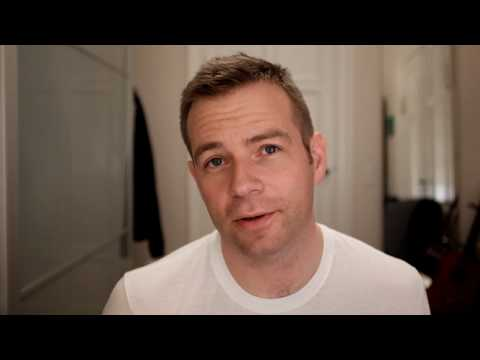

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

##### Exercise: Use the concept of modularity to explore how community-like the genres are.

<font color='gray'> Explain the concept of modularity in your own words. </font>

Modularity is a measure of how well a network can be divided into communities. It is a measure of the density of links inside communities compared to links between communities. A network with high modularity has dense connections between nodes in the same community and sparse connections between nodes in different communities.

<font color='gray'> Work from the undirected version of the network, keeping only the nodes for which you have genre information in the file above. </font>

In [5]:
import pandas as pd
import json
import networkx as nx

# Load the data
url = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt'
data = pd.read_json(url, orient='index')

# Convert to dictionary
genres = data.to_dict()[0]  

# Initialize new undirected graph
G = nx.Graph()

# Add nodes with genre information
for artist, genre_list in genres.items():
    G.add_node(artist, genres=genre_list)

# Add edges between artists who share genres
for artist1, genres1 in genres.items():
    for artist2, genres2 in genres.items():
        if artist1 != artist2:
            common_genres = set(genres1).intersection(genres2)
            if common_genres:  
                G.add_edge(artist1, artist2, weight=len(common_genres))  

# Subgraph containing only artists in dataset
artists = list(genres.keys())
G = G.subgraph(artists)

# Print graph information
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1833 nodes and 1657291 edges.
